In [1]:
import os
import scipy
from tqdm import tqdm
from typing import Union

import torch
import torchvision
import torchvision.transforms as transforms
from pathlib import Path

from Model.Model import Modified_VGG19
from Functions.ImageOps import *
from Functions.DataOps  import *
from Functions.tmp import *

In [2]:
# Define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# Image Name
image_name = 'rock.jpg'

In [4]:
# Load Image Path
ImagePath = (Path(os.path.abspath('')) / 'Saves' / image_name).resolve()
ImagePath

WindowsPath('D:/ComputerScience/CV/Final Project/Project/Saves/rock.jpg')

In [5]:
# Load Image
image_data = read_image(ImagePath).to(device)
white_data = create_white_noise_image(image_data).to(device)

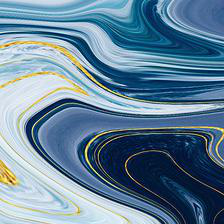

In [6]:
# Show Image
show_image(image_data, False)

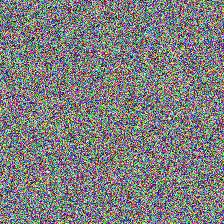

In [7]:
show_image(white_data, False)

In [8]:
# Load Model
model = Modified_VGG19(device=device)

In [9]:
# Print Model Layer Name
layer_names = model.get_model_layer_names()
layer_names

['conv1_1',
 'relu1_1',
 'conv1_2',
 'relu1_2',
 'pool1',
 'conv2_1',
 'relu2_1',
 'conv2_2',
 'relu2_2',
 'pool2',
 'conv3_1',
 'relu3_1',
 'conv3_2',
 'relu3_2',
 'conv3_3',
 'relu3_3',
 'conv3_4',
 'relu3_4',
 'pool3',
 'conv4_1',
 'relu4_1',
 'conv4_2',
 'relu4_2',
 'conv4_3',
 'relu4_3',
 'conv4_4',
 'relu4_4',
 'pool4',
 'conv5_1',
 'relu5_1',
 'conv5_2',
 'relu5_2',
 'conv5_3',
 'relu5_3',
 'conv5_4']

In [10]:
# The first run model
model(image_data)
# Get feature maps
feature_maps = { key : value.detach() for key, value in model.get_feature_maps().items() }
# Clear grad data
model.zero_grad()

In [11]:
# Define Aid Functions
import re
list_to_dict1 = lambda x : { item : 1.0 for item in x }

def list_to_dict2(layer_names : list[str], name : str) -> dict[str, float] :
    ret_value = { }
    find_or_not = False
    
    for item in layer_names : 
        if ( item != name ):
            ret_value[item] = 1.0
        else :
            find_or_not = True
            ret_value[item] = 1.0
            break
            
    assert find_or_not == True
    return ret_value

def list_to_dict3(layer_names : list[str], pattern : str) -> dict[str, float] :
    ret_value = { }
    find_or_not = False
    for item in layer_names:
        if re.search(pattern, item):
            find_or_not = True
            ret_value[item] = 1.0
    
    assert find_or_not == True
    return ret_value

In [12]:
# Define run
def train(model,
          feature_maps : dict[str, torch.Tensor],
          image_data : torch.Tensor,
          weights    : dict[str, float],
          optimizer,
          device     : torch.cuda.device,
          loops:int) -> torch.Tensor:
    
    for i in tqdm(range(loops)):
        def closure():
            optimizer.zero_grad()
            train_feature_maps = model(image_data)
            l = loss(feature_maps, train_feature_maps, weights=weights, device=device)
            l.backward()
            # print(l)
            return l
        
        optimizer.step(closure)
#         closure()
#         optimizer.step()
        
    return optimizer.param

In [13]:
import torch.optim as optim

生成图片

In [14]:
# Define Image Save Path
tmp       = (Path(os.path.abspath('')) / 'Running').resolve()
if not os.path.exists(tmp) :
    os.mkdir(tmp)

In [15]:
def main(image_data : torch.Tensor,
         weights_func : str,
         weights_list : Union[str, list[str]],
         optimizer_name : str,
         loops_num : int) -> torch.Tensor:
    global feature_maps, model, layer_names
    
    data = image_data.detach().requires_grad_(True)
    
    if optimizer_name == 'LBFGS' :
        optimizer = optim.LBFGS([data], lr=1, max_iter=20)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW([data])
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD([data], lr=0.0001)
    else :
        raise RuntimeError(f'Unrecognized optimizer: {optimizer}')
        
    if weights_func == 'list_to_dict1':
        weights = eval(weights_func)(weights_list)
    elif weights_func == 'list_to_dict2':
        weights = eval(weights_func)(layer_names, weights_list)
    elif weights_func == 'list_to_dict3':
        weights = eval(weights_func)(layer_names, weights_list)
    else :
        raise RuntimeError(f'Unrecognized weights_func: {weights_func}')

    print(weights)
    train(model, feature_maps, data, weights, optimizer, device, loops_num)
    
    return data

In [16]:
# 不同层的比较
layers = ['pool4']
# Limit the parameter func : 'list_to_dict1'
# layers = ['conv1_1', 'pool1', 'pool2', 'pool3', 'pool4']

for layer in layers:
    tmp = image_name.split('.')
    tmp_name = tmp[0] + '_' + 'LBFGS' + '.' + tmp[1]
    save_path = (Path(os.path.abspath('')) / 'Running' / tmp_name).resolve()
    data = main(image_data=white_data, 
                weights_func='list_to_dict2',
                weights_list=layer,
                optimizer_name='LBFGS',
                loops_num=120)
    show_image(data, show=False).save(save_path)
    print(f'Image saved at {save_path}')

{'conv1_1': 1.0, 'relu1_1': 1.0, 'conv1_2': 1.0, 'relu1_2': 1.0, 'pool1': 1.0, 'conv2_1': 1.0, 'relu2_1': 1.0, 'conv2_2': 1.0, 'relu2_2': 1.0, 'pool2': 1.0, 'conv3_1': 1.0, 'relu3_1': 1.0, 'conv3_2': 1.0, 'relu3_2': 1.0, 'conv3_3': 1.0, 'relu3_3': 1.0, 'conv3_4': 1.0, 'relu3_4': 1.0, 'pool3': 1.0, 'conv4_1': 1.0, 'relu4_1': 1.0, 'conv4_2': 1.0, 'relu4_2': 1.0, 'conv4_3': 1.0, 'relu4_3': 1.0, 'conv4_4': 1.0, 'relu4_4': 1.0, 'pool4': 1.0}


  0%|                                                                                                                                                                   | 0/120 [00:00<?, ?it/s]


TypeError: LBFGS.step() missing 1 required positional argument: 'g_Ok'

In [ ]:
show_image(data, False)